<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/8-dimensionality-reduction/02_dimensionality_reduction_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dimensionality Reduction Exercise

**Principal Component Analysis** (PCA) is by far the most popular dimensionality reduction
algorithm. First it identifies the hyperplane that lies closest to the data, and then
it projects the data onto it.

<img src='https://github.com/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/8-dimensionality-reduction/images/0.png?raw=1' width='600'/>

**Preserving the Variance**

Before you can project the training set onto a lower-dimensional hyperplane, you
first need to choose the right hyperplane.

For example, a simple 2D dataset is represented
on the left in figure, along with three different axes (i.e., 1D hyperplanes).
On the right is the result of the projection of the dataset onto each of these axes.

<img src='https://github.com/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/8-dimensionality-reduction/images/1.png?raw=1' width='600'/>

As you can see, the projection onto the solid line preserves the maximum variance, while
the projection onto the dotted line preserves very little variance and the projection
onto the dashed line preserves an intermediate amount of variance.

It seems reasonable to select the axis that preserves the maximum amount of variance,
as it will most likely lose less information than the other projections. Another
way to justify this choice is that it is the axis that minimizes the mean squared distance
between the original dataset and its projection onto that axis. This is the rather
simple idea behind [**PCA**](https://www.tandfonline.com/doi/pdf/10.1080/14786440109462720).













##Setup

In [1]:
# Common imports
import numpy as np
import os
import time

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.datasets import make_swiss_roll
from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

##PCA with Random Forest classifier and Logistic Regression

We will do the following experiments in this section:

1. Load the MNIST dataset and split it into a training set
and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing). 

2. Train a Random Forest classifier on the dataset and time how
long it takes, then evaluate the resulting model on the test set. 

3. Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%.

4. Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster? 

5. Next, evaluate the classifier on the test set. How
does it compare to the previous classifier?

###Exercise-1

Load the MNIST dataset and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).

In [3]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
x_train, y = mnist["data"], mnist["target"]
x_train.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
x_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

x_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [6]:
(x_train.shape, y_train.shape)

((60000, 784), (60000,))

In [7]:
(x_test.shape, y_test.shape)

((10000, 784), (10000,))

###Exercise-2

Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.

In [8]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)

In [9]:
t0 = time.time()
rnd_clf.fit(x_train, y_train)
t1 = time.time()

In [10]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 4.99s


In [12]:
y_pred = rnd_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.9492

###Exercise-3

Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.

In [13]:
pca = PCA(n_components=0.95)
x_train_reduced = pca.fit_transform(x_train)

###Exercise-4

Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster?

In [14]:
rnd_clf2 = RandomForestClassifier(n_estimators=10, random_state=42)

t0 = time.time()
rnd_clf2.fit(x_train_reduced, y_train)
t1 = time.time()

print("Training took {:.2f}s".format(t1 - t0))

Training took 14.12s


Oh no! Training is actually more than twice slower now! How can that be? Well, as we saw, dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm.

If you try a softmax classifier instead of a random forest classifier, you will find that training time is reduced by a factor of 3 when using PCA. Actually, we will do this in a second, but first let's check the precision of the new random forest classifier.

###Exercise-5

Next evaluate the classifier on the test set: how does it compare to the previous classifier?

In [15]:
x_test_reduced = pca.transform(x_test)

y_pred = rnd_clf2.predict(x_test_reduced)
accuracy_score(y_test, y_pred)

0.9009

It is common for performance to drop slightly when reducing dimensionality, because we do lose some useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training and reduced performance. :(

Let's see if it helps when using softmax regression:

In [ ]:
log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)

t0 = time.time()
log_clf.fit(x_train, y_train)
t1 = time.time()

In [18]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 49.22s


In [17]:
y_pred = log_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.9255

Okay, so softmax regression takes much longer to train on this dataset than the random forest classifier, plus it performs worse on the test set. But that's not what we are interested in right now, we want to see how much PCA can help softmax regression. 

Let's train the softmax regression model using the reduced dataset:

In [ ]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)

t0 = time.time()
log_clf2.fit(x_train_reduced, y_train)
t1 = time.time()

In [20]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 16.23s


Nice! Reducing dimensionality led to a 4× speedup. :) 

Let's check the model's accuracy:

In [21]:
y_pred = log_clf2.predict(x_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

A very slight drop in performance, which might be a reasonable price to pay for a 4× speedup, depending on the application.

So there you have it: PCA can give you a formidable speedup... but not always!

##t-SNE for data visualization

We will use `t-SNE` to reduce the `MNIST` dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent
each image’s target class. 

Alternatively, you can replace each dot in the
scatterplot with the corresponding instance’s class (a digit from 0 to 9), or even
plot scaled-down versions of the digit images themselves (if you plot all digits,
the visualization will be too cluttered, so you should either draw a random sample
or plot an instance only if no other instance has already been plotted at a
close distance). 

You should get a nice visualization with well-separated clusters of
digits. Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

###Exercise-1

Dimensionality reduction on the full 60,000 images takes a very long time, so let's only do this on a random subset of 10,000 images:

In [32]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx].astype(int)

Now let's use t-SNE to reduce dimensionality down to 2D so we can plot the dataset:

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
x_reduced = tsne.fit_transform(X)

Now let's use Matplotlib's `scatter()` function to plot a scatterplot, using a different color for each digit:

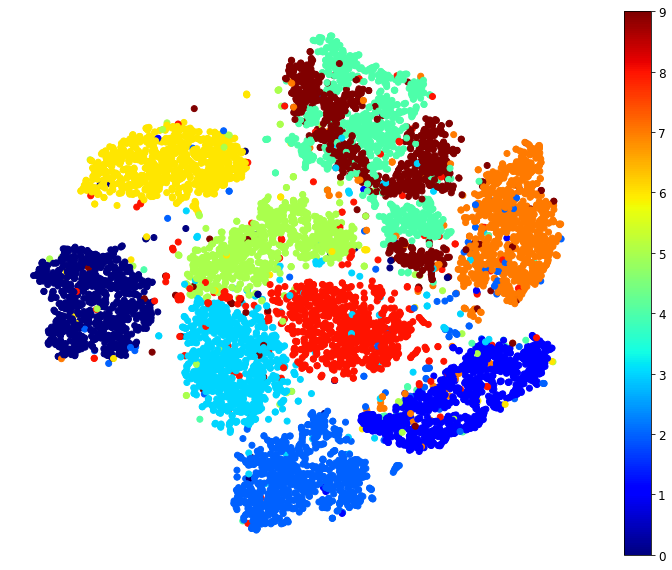

In [33]:
plt.figure(figsize=(13,10))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

Isn't this just beautiful? :) 

This plot tells us which numbers are easily distinguishable from the others (e.g., 0s, 6s, and most 8s are rather well separated clusters), and it also tells us which numbers are often hard to distinguish (e.g., 4s and 9s, 5s and 3s, and so on).

Let's focus on digits 3 and 5, which seem to overlap a lot.

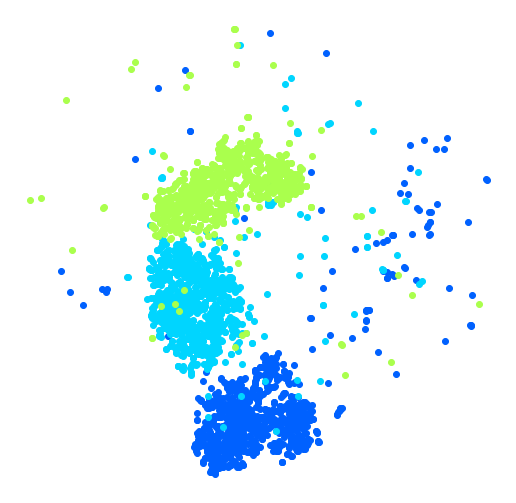

In [34]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(x_reduced[y == digit, 0], x_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Let's see if we can produce a nicer image by running t-SNE on these 3 digits:

In [ ]:
idx = (y == 2) | (y == 3) | (y == 5) 
x_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
x_subset_reduced = tsne_subset.fit_transform(x_subset)

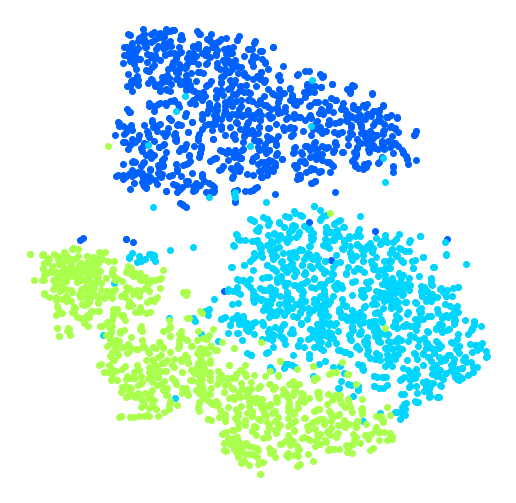

In [36]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(x_subset_reduced[y_subset == digit, 0], x_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Much better, now the clusters have far less overlap. But some 3s are all over the place. Plus, there are two distinct clusters of 2s, and also two distinct clusters of 5s. It would be nice if we could visualize a few digits from each cluster, to understand why this is the case. Let's do that now.

###Exercise-2

Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits.

Let's create a `plot_digits()` function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead.

In [37]:
def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

Let's try it! First let's just write colored digits:

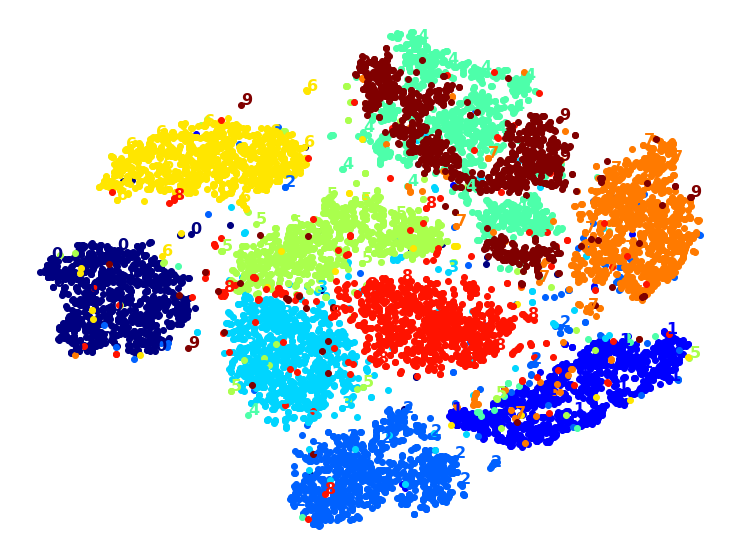

In [38]:
plot_digits(x_reduced, y)

Well that's okay, but not that beautiful. Let's try with the digit images:

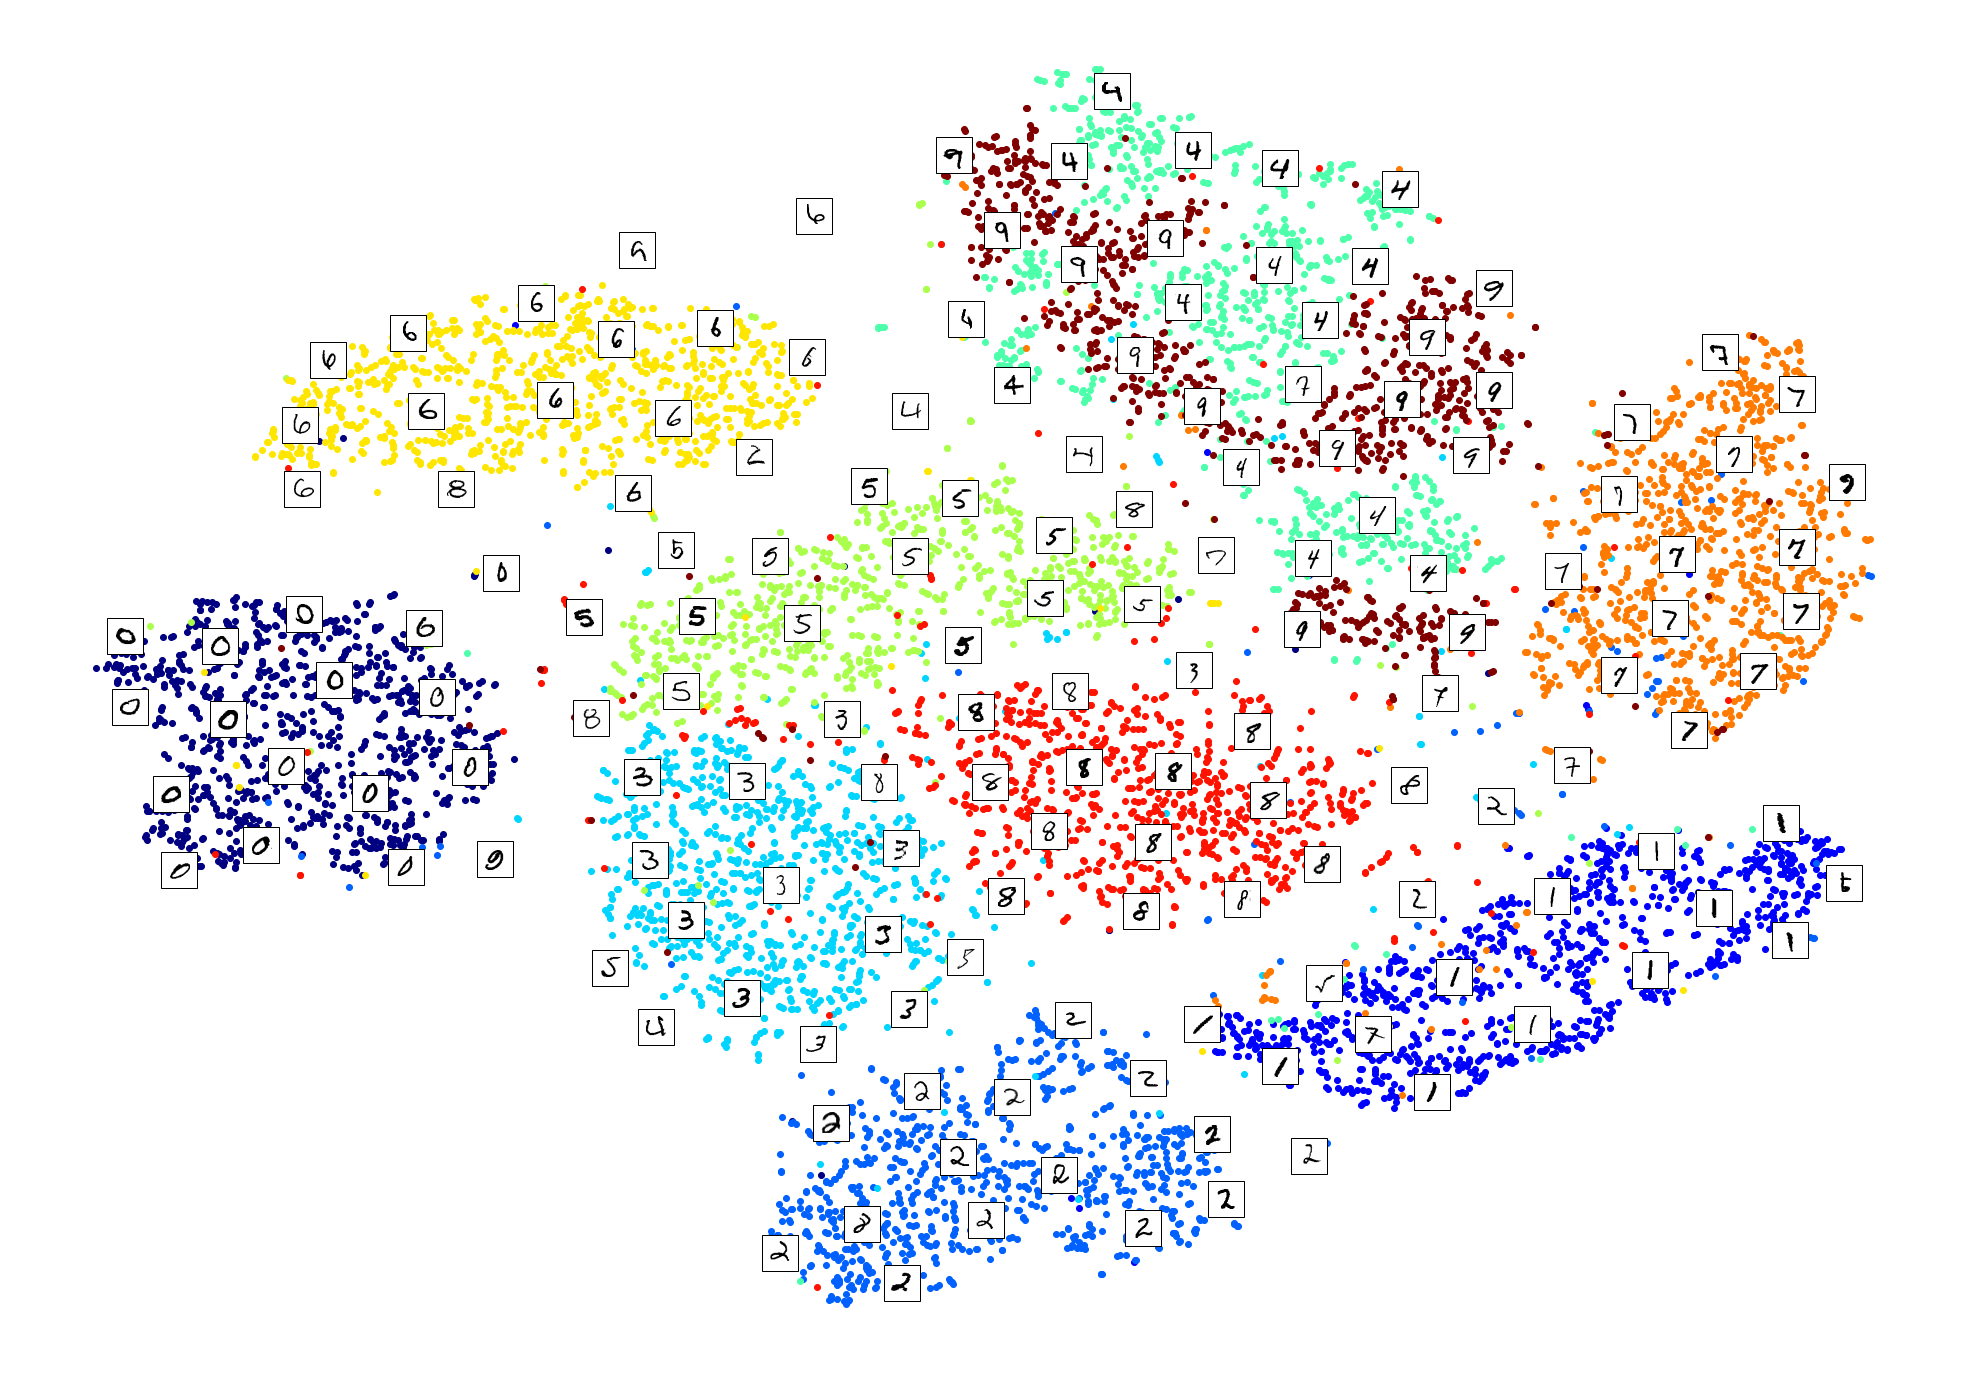

In [39]:
plot_digits(x_reduced, y, images=X, figsize=(35, 25))

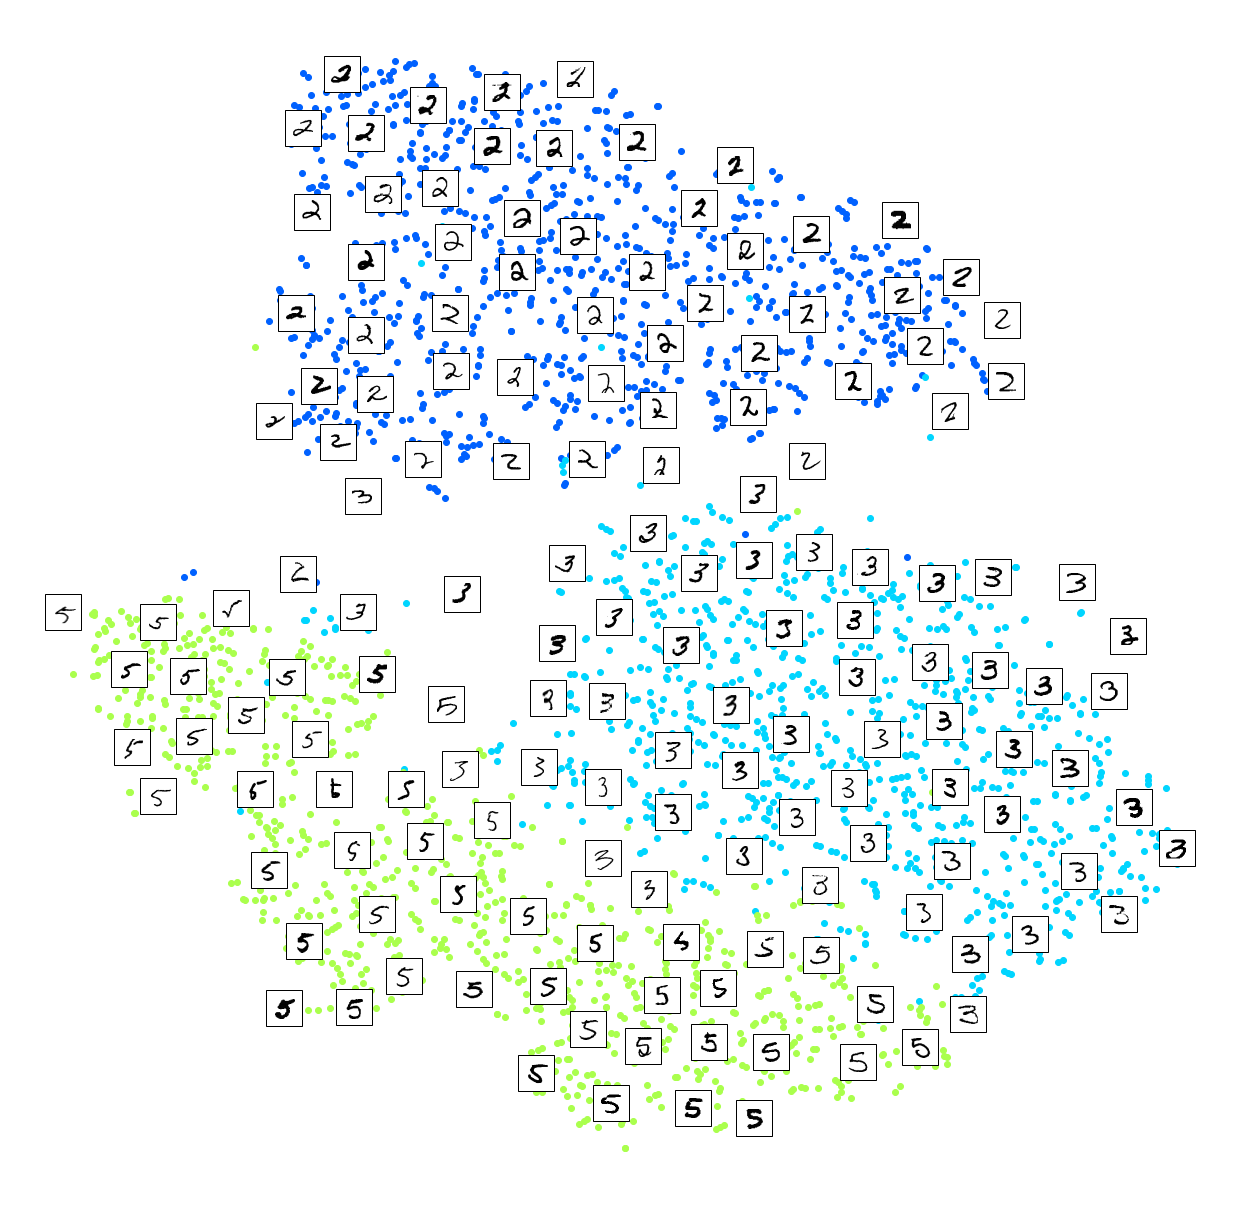

In [40]:
plot_digits(x_subset_reduced, y_subset, images=x_subset, figsize=(22, 22))

###Exercise-3

Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

Let's start with PCA. We will also time how long it takes:

In [43]:
t0 = time.time()
x_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()

print("PCA took {:.1f}s.".format(t1 - t0))

PCA took 1.0s.


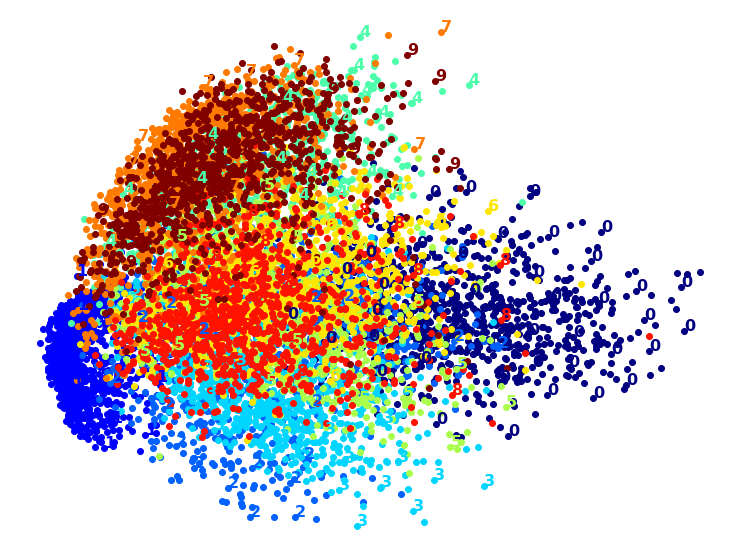

In [44]:
plot_digits(x_pca_reduced, y)
plt.show()

Wow, PCA is blazingly fast! But although we do see a few clusters, there's way too much overlap. 

Let's try LLE:

In [45]:
t0 = time.time()
x_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()

print("LLE took {:.1f}s.".format(t1 - t0))

LLE took 35.0s.


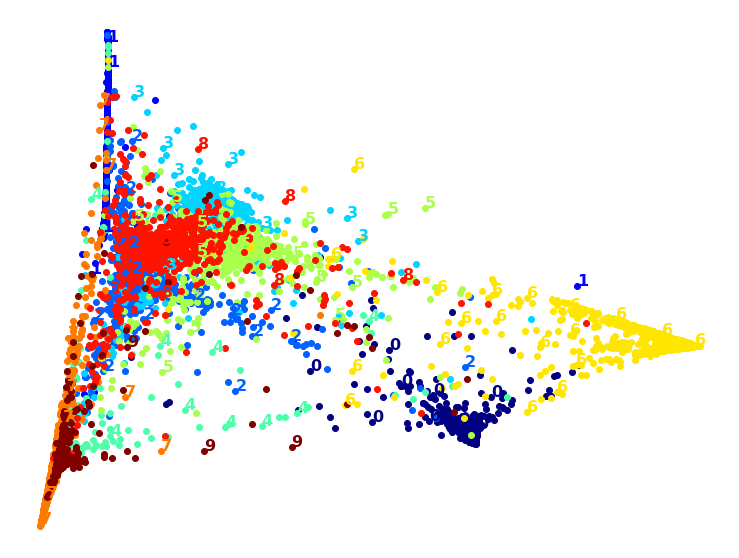

In [46]:
plot_digits(x_lle_reduced, y)
plt.show()

That took a while, and the result does not look too good. 

Let's see what happens if we apply PCA first, preserving 95% of the variance:

In [47]:
pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])

t0 = time.time()
x_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()

print("PCA+LLE took {:.1f}s.".format(t1 - t0))

PCA+LLE took 38.4s.


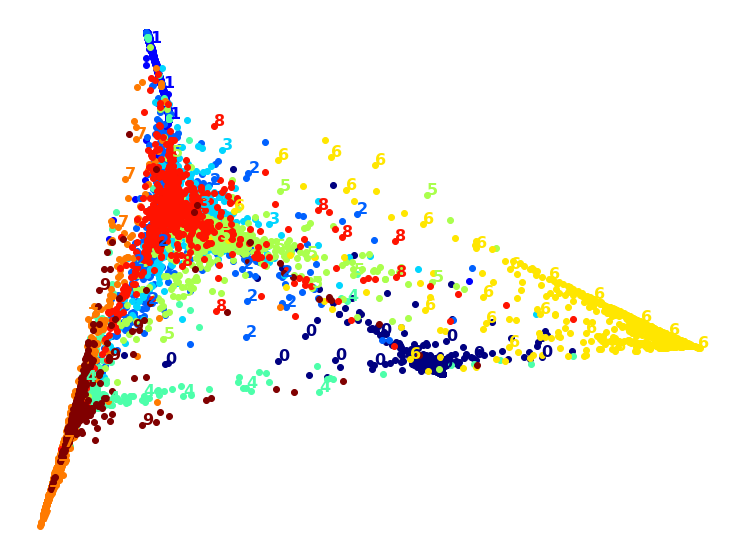

In [48]:
plot_digits(x_pca_lle_reduced, y)
plt.show()

The result is more or less the same, but this time it was almost 4× faster.

Let's try MDS. It's much too long if we run it on 10,000 instances, so let's just try 2,000 for now:

In [49]:
m = 2000
t0 = time.time()
x_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()

print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))

MDS took 195.9s (on just 2,000 MNIST images instead of 10,000).


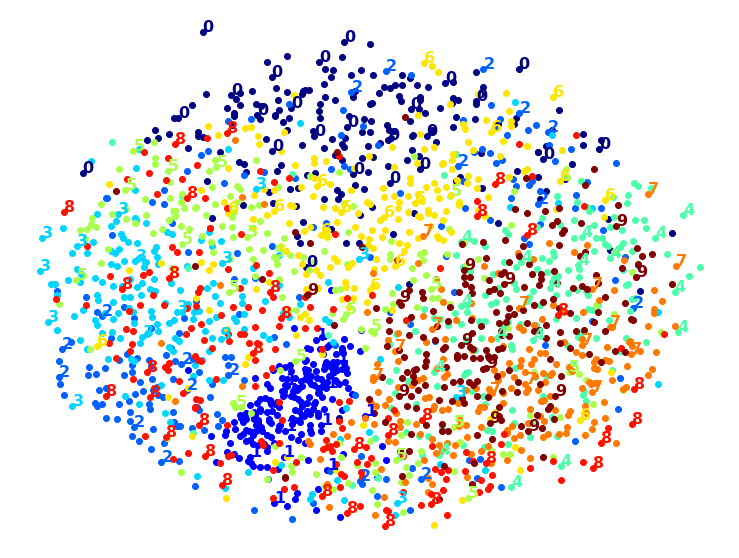

In [50]:
plot_digits(x_mds_reduced, y[:m])
plt.show()

 This does not look great, all clusters overlap too much. 
 
 Let's try with PCA first, perhaps it will be faster?

In [51]:
pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])

t0 = time.time()
x_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()

print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))

PCA+MDS took 155.4s (on 2,000 MNIST images).


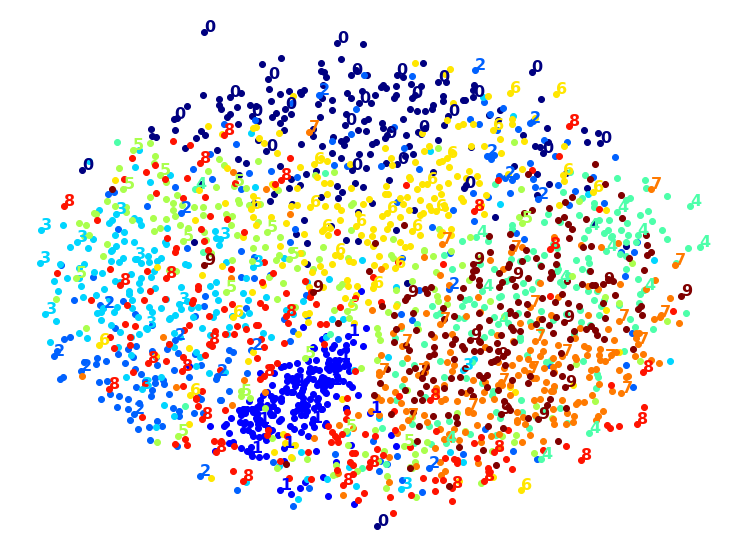

In [52]:
plot_digits(x_pca_mds_reduced, y[:2000])
plt.show()

Same result, and no speedup: PCA did not help (or hurt).

Let's try LDA:

In [53]:
t0 = time.time()
x_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()

print("LDA took {:.1f}s.".format(t1 - t0))

LDA took 3.2s.


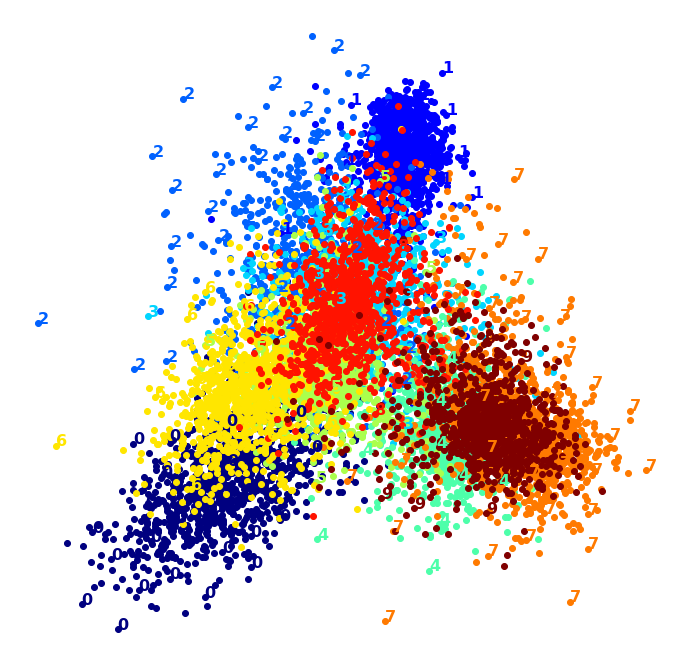

In [54]:
plot_digits(x_lda_reduced, y, figsize=(12,12))
plt.show()

This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

Well, it's pretty clear that t-SNE won this little competition, wouldn't you agree? We did not time it, so let's do that now:

In [ ]:
t0 = time.time()
x_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()

print("t-SNE took {:.1f}s.".format(t1 - t0))

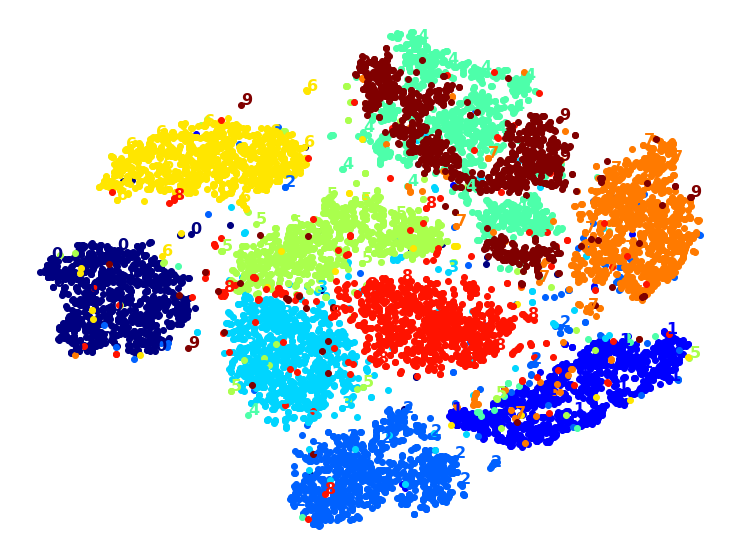

In [56]:
plot_digits(x_tsne_reduced, y)
plt.show()

It's twice slower than LLE, but still much faster than MDS, and the result looks great. 

Let's see if a bit of PCA can speed it up:

In [ ]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])

t0 = time.time()
x_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()

print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))

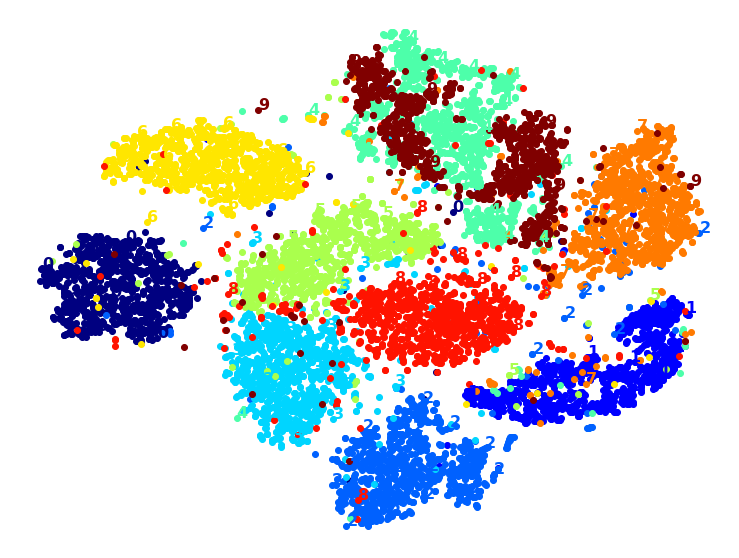

In [58]:
plot_digits(x_pca_tsne_reduced, y)
plt.show()

Yes, PCA roughly gave us a 25% speedup, without damaging the result. We have a winner!